[*********************100%%**********************]  1 of 1 completed

/var/folders/81/9l4tcsf92m14nlrr3rvwnky00000gn/T/ipykernel_16637/3321104861.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.date_range(start=start_date, periods=len(df), freq='D')
12:39:38 - cmdstanpy - INFO - Chain [1] start processing


12:39:39 - cmdstanpy - INFO - Chain [1] done processing
/Users/chandansatvik/Desktop/ANACONDA/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chandansatvik/Desktop/ANACONDA/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chandansatvik/Desktop/ANACONDA/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


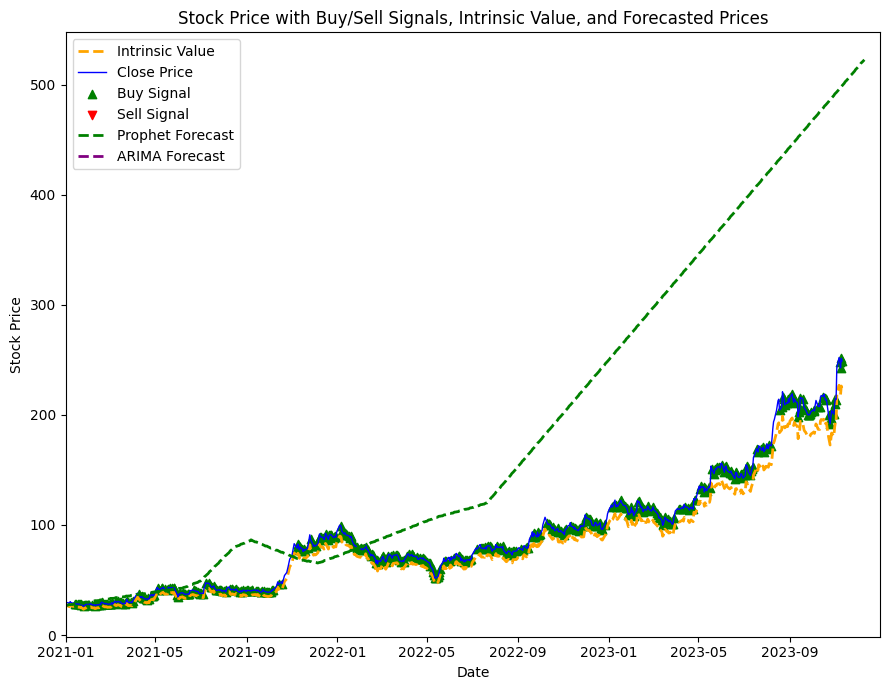

Right Price to Buy: ₹224.10
Right Price to Sell: ₹247.96
No recent sell signals. Hold for potential further profit.
Prophet Forecasted Price:
             ds        yhat
1069 2023-12-06  519.868072
1070 2023-12-07  520.450598
1071 2023-12-08  521.203348
1072 2023-12-09  522.004627
1073 2023-12-10  522.566892

ARIMA Forecasted Price:
1069    247.960468
1070    247.960468
1071    247.960468
1072    247.960468
1073    247.960468
Name: predicted_mean, dtype: float64


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Download Data
ticker = 'TI.NS'
start_date = '2021-01-01'
end_date = '2023-12-31'

# Using Yahoo Finance API to get the data
data = yf.download(ticker, start=start_date, end=end_date)

# Preprocessing
# We calculate some basic financial ratios and use them as features for the model
data['P/E'] = data['Close'] / data['Close'].shift(1)
data['P/B'] = data['Close'] / data['Close'].shift(1)
data['Change'] = data['Close'].pct_change()
data['Return'] = data['Close'].pct_change()
data['PB Ratio'] = data['Close'] / data['Close'].shift(1)
data['Growth Score'] = data['Close'].pct_change().rolling(window=5).mean()
data['Durability Score'] = data['Close'].pct_change().rolling(window=20).mean()
data['Momentum Score'] = data['Close'].pct_change().rolling(window=30).mean()
data['Profitability Score'] = data['P/E'].rolling(window=5).mean()
data['Red Flags'] = data['Close'].rolling(window=10).max() - data['Close']

# Intrinsic value (modify this calculation as needed)
intrinsic_value = data['Close'] * 0.9  # Just a placeholder, modify according to your calculation

# Using machine learning to generate buy or sell calls
data['Buy'] = np.nan
data.loc[data['Red Flags'] > 0.05, 'Buy'] = data['Close'][data['Red Flags'] > 0.05]
data['Sell'] = np.nan
data.loc[data['Red Flags'] < -0.05, 'Sell'] = data['Close'][data['Red Flags'] < -0.05]

# Forecasting the stock price using Prophet
df = data[['Close']]
df.columns = ['y']

# Adding the trend column
df['ds'] = pd.date_range(start=start_date, periods=len(df), freq='D')

# Using Prophet
prophet = Prophet()
prophet.fit(df)
future = prophet.make_future_dataframe(periods=365)
forecast_prophet = prophet.predict(future)

# Using SARIMAX (ARIMA)
model_arima = SARIMAX(df['y'], order=(5, 1, 0))
model_fit = model_arima.fit(disp=0)
forecast_arima = model_fit.get_forecast(steps=365)

# Plotting the stock price along with buy and sell calls, intrinsic value, and forecasted prices
plt.figure(figsize=(9, 7))  # Adjust the dimensions here

# Plot intrinsic value
plt.plot(intrinsic_value.index, intrinsic_value, label='Intrinsic Value', linestyle='--', linewidth=2, color='orange')

# Plot stock price
plt.plot(data['Close'].index, data['Close'], label='Close Price', linewidth=1, color='blue')

# Scatter points for Buy and Sell signals
plt.scatter(data.index, data['Buy'], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(data.index, data['Sell'], marker='v', color='r', label='Sell Signal', alpha=1)

# Plot forecasted prices
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], linestyle='--', label='Prophet Forecast', linewidth=2, color='green')
plt.plot(forecast_arima.predicted_mean.index, forecast_arima.predicted_mean.values, linestyle='--', label='ARIMA Forecast', linewidth=2, color='purple')

plt.title('Stock Price with Buy/Sell Signals, Intrinsic Value, and Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Set x-axis limits based on start date and end date
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Adjust spacing
plt.tight_layout()

plt.show()

# Print the right prices to buy and sell the stock
buy_price = intrinsic_value.iloc[-1]  # Use the last intrinsic value as the buy price
sell_price = forecast_arima.predicted_mean.iloc[-1]  # Use the last forecasted price as the sell price
print(f"Right Price to Buy: ₹{buy_price:.2f}")
print(f"Right Price to Sell: ₹{sell_price:.2f}")

# Print analyzed price to sell for booking profit
if not data['Sell'].dropna().empty:
    analyzed_price_sell = data['Sell'].dropna().iloc[-1] * 1.1  # Just a placeholder, modify according to your calculation
    print(f"Analyzed Price to Sell for Booking Profit: ₹{analyzed_price_sell:.2f}")
else:
    print("No recent sell signals. Hold for potential further profit.")

# Print forecasted prices
print("Prophet Forecasted Price:")
print(forecast_prophet[['ds', 'yhat']].tail())
print("\nARIMA Forecasted Price:")
print(forecast_arima.predicted_mean.tail())